In [1]:
# Importing libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import statsmodels.api as sm

# 1. Using ARIMA to predict stock prices

## 1.1 Retrieving STI history data from yahoo finance
### -Retrieving history of STI as ticker and extract past history from it
### -History extracted consist of every record yahoo finance has, with period set as max
### -Dividends and stock splits are dropped since they are of no used

In [2]:
# Loading STI's history into a dataframe
sti= yf.Ticker("^sti")
sti_df = sti.history(period='max')
sti_df.drop(["Dividends","Stock Splits"], axis=1, inplace=True)
sti_df

,Open,High,Low,Close,Volume
Date,,,,,
1987-12-28,824.400024,824.400024,824.400024,824.400024,0
1987-12-29,810.900024,810.900024,810.900024,810.900024,0
1987-12-30,823.200012,823.200012,823.200012,823.200012,0
1988-01-04,833.599976,833.599976,833.599976,833.599976,0
1988-01-05,879.299988,879.299988,879.299988,879.299988,0
...,...,...,...,...,...
2022-12-27,3277.580078,3277.939941,3264.030029,3266.379883,108508800
2022-12-28,3257.750000,3270.330078,3256.239990,3266.969971,121539700
2022-12-29,3255.100098,3257.000000,3234.929932,3249.239990,138022600


## 1.2 Visualizing time series

<AxesSubplot:xlabel='Date'>

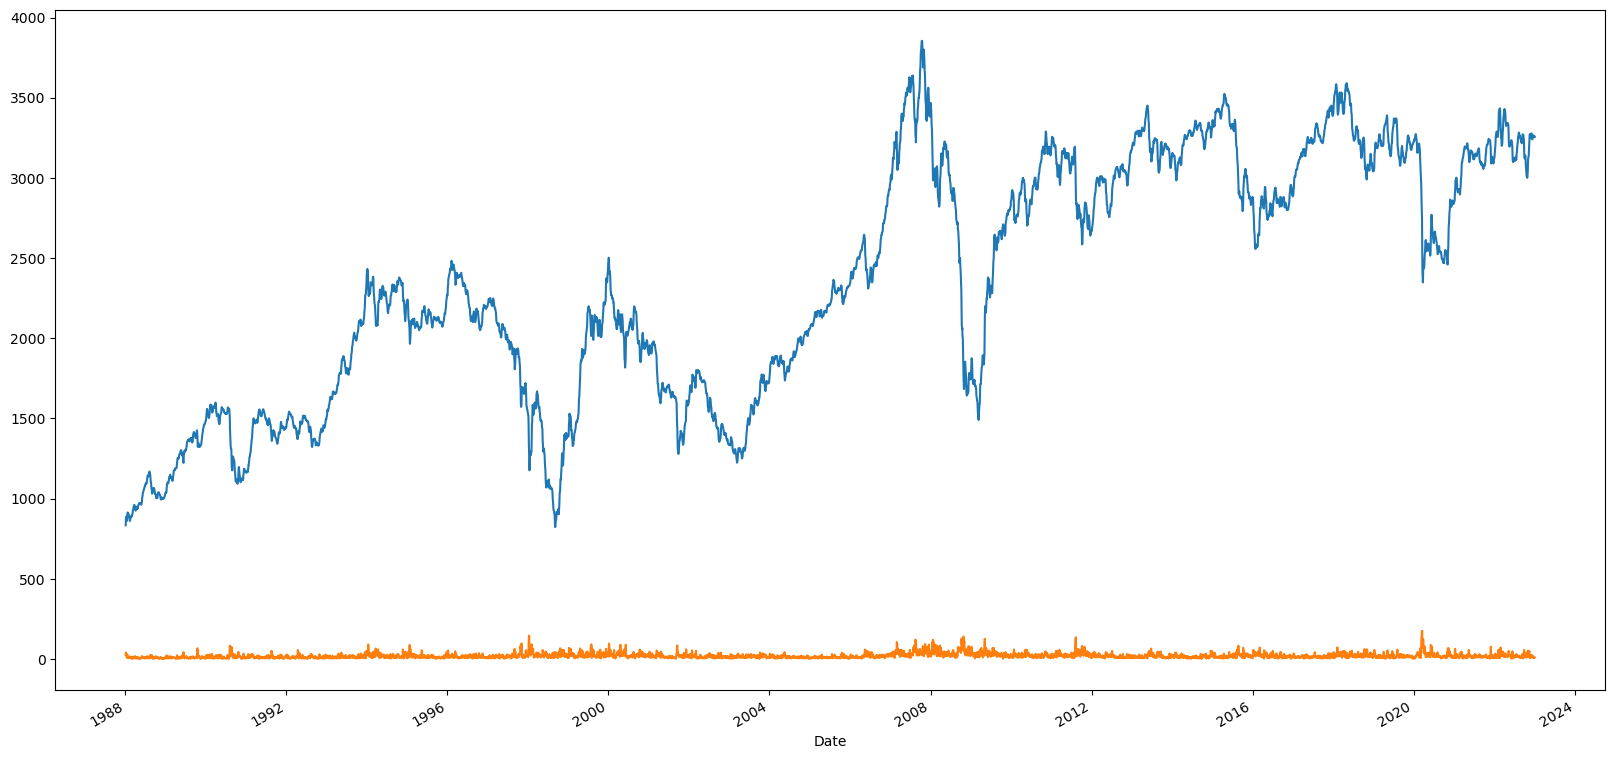

In [3]:
sti_df["Close"].rolling(5).mean().plot(figsize=(20,10))
sti_df["Close"].rolling(5).std().plot()

## 1.3 Using ETS decomposition to visualize general trend of data

<Figure size 640x480 with 0 Axes>

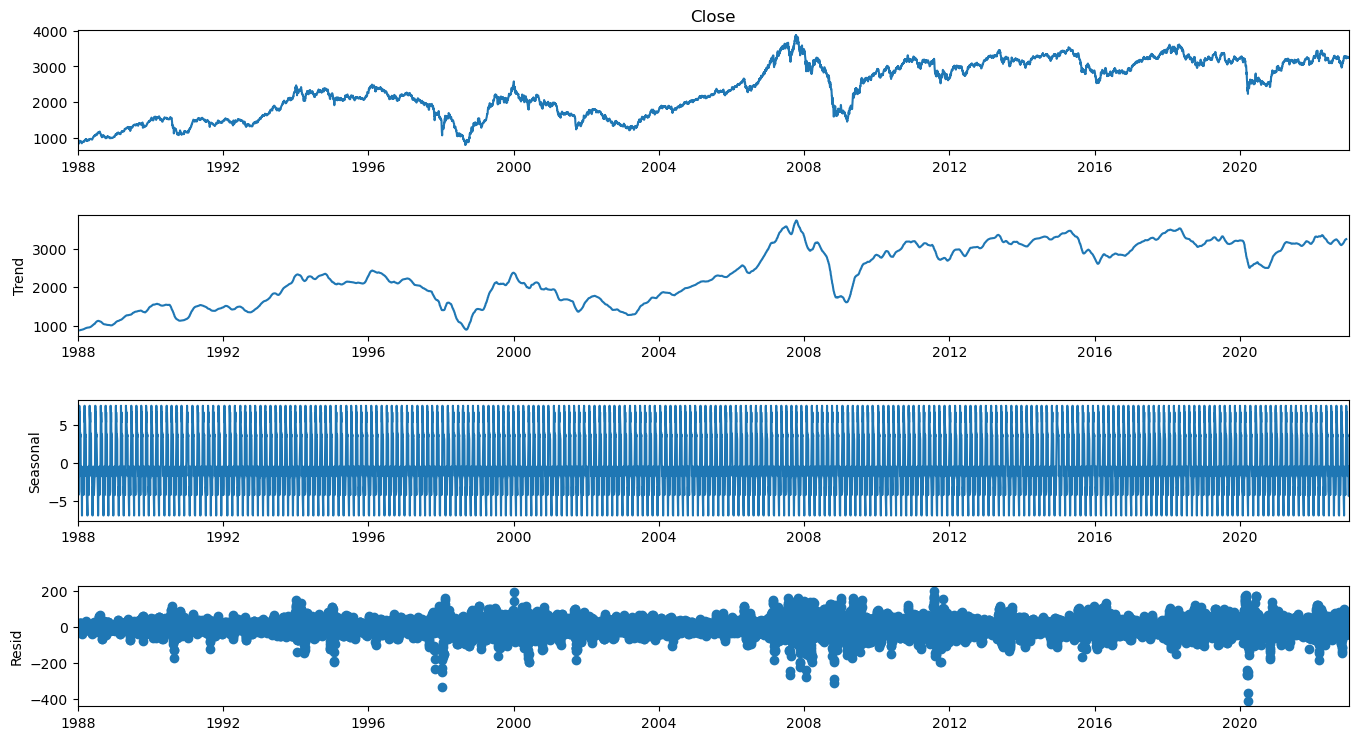

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sti_df["Close"], period = 35)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

## 1.4 Testing of stationary using Dickey Fuller

In [5]:
# Import Dickey Fuller library
from statsmodels.tsa.stattools import adfuller

In [6]:
# Function to check whether data is stationary or not using Dickey Fuller
def adf_check(time_series):
    """
    Pass in a time series, return ADF report
    """
    result = adfuller(time_series)
    print("Augmented Dickey-Fuller Test:")
    labels = ["Adf Test Statistic", "p-value", "#Lags Used", "Number of Observation Used"]

    for value, label in zip(result, labels):
        print(label + " : " + str(value))
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis, reject null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

In [7]:
# Checking whether sti_df data is stationary
adf_check(sti_df["Close"])

Augmented Dickey-Fuller Test:
Adf Test Statistic : -2.0941919675953184
p-value : 0.2468564450180203
#Lags Used : 15
Number of Observation Used : 8729
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


## 1.4 Using differencing technique, to make data stationary

In [8]:
# Differencing technique by using .shift by one
sti_df["Close_diff"] = sti_df["Close"] - sti_df["Close"].shift(1)
adf_check(sti_df["Close_diff"].dropna())

Augmented Dickey-Fuller Test:
Adf Test Statistic : -23.39974129837481
p-value : 0.0
#Lags Used : 14
Number of Observation Used : 8729
Strong evidence against null hypothesis, reject null hypothesis. Data has no unit root and is stationary


## 1.5 Setting differencing (d notion or i notion in ARIMA) as one, as only observed difference of one to establish whether data is stationary

<AxesSubplot:xlabel='Date'>

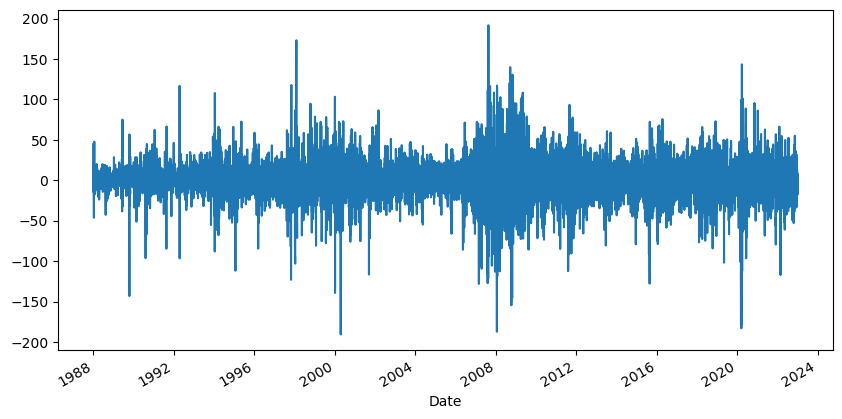

In [9]:
# Plotting to check stationary pattern
sti_df["Close_diff"].plot(figsize=(10,5))

## 1.6 Finding the p (ACF) and q (PARF) which are the lags for the AR and MA models

c:\Users\User\anaconda3\envs\mages\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


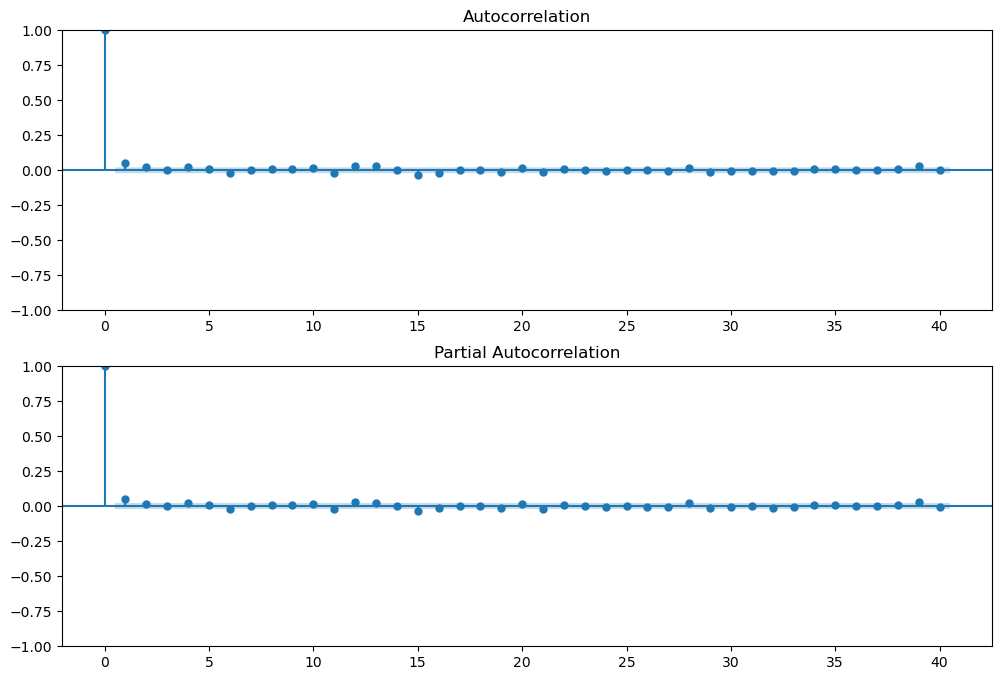

In [10]:
# Plotting ACF and PARF to find p lag and q lag
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sti_df["Close_diff"].iloc[13:], ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sti_df["Close_diff"].iloc[13:], ax=ax2)

p is the number of lag observations included in the model, the number before the first inverted bar in the ACF(Start from zero)
q is the size of moving average window(order of moving average), number before the first inverted bar in PACF(Start from zero)
For sti p is 2 and q is 1

## 1.7 Constructing SARIMAX
Since it is observed there is seasonal pattern, SARIMAX is used instead of ARIMA

In [11]:
# Split into train and test data
sti_train = sti_df[sti_df.index.year < 2022]
sti_test = sti_df[sti_df.index.year == 2022]

In [12]:
# Initiate SARIMAX with the settings oberserved from above
sarimax_model = sm.tsa.statespace.SARIMAX(sti_train["Close"], order=(2,1,2), seasonal_order=(2,1,2,12))

# Fitting and showing the results
results = sarimax_model.fit()
print(results.summary())

c:\Users\User\anaconda3\envs\mages\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\envs\mages\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 8494
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood              -39427.647
Date:                            Tue, 03 Jan 2023   AIC                          78873.293
Time:                                    22:48:33   BIC                          78936.704
Sample:                                         0   HQIC                         78894.934
                                           - 8494                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6993      0.654      1.069      0.285      -0.583       1.981
ar.L2         -0.0022      0.325   

## 1.8 Showing prediction from SARIMAX and calculating how good the prediction is

c:\Users\User\anaconda3\envs\mages\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\AppData\Local\Temp\ipykernel_6416\1353654720.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sti_test["Prediction"] = predictions


<AxesSubplot:title={'center':'ARIMA model predictions'}, xlabel='Date', ylabel='Price'>

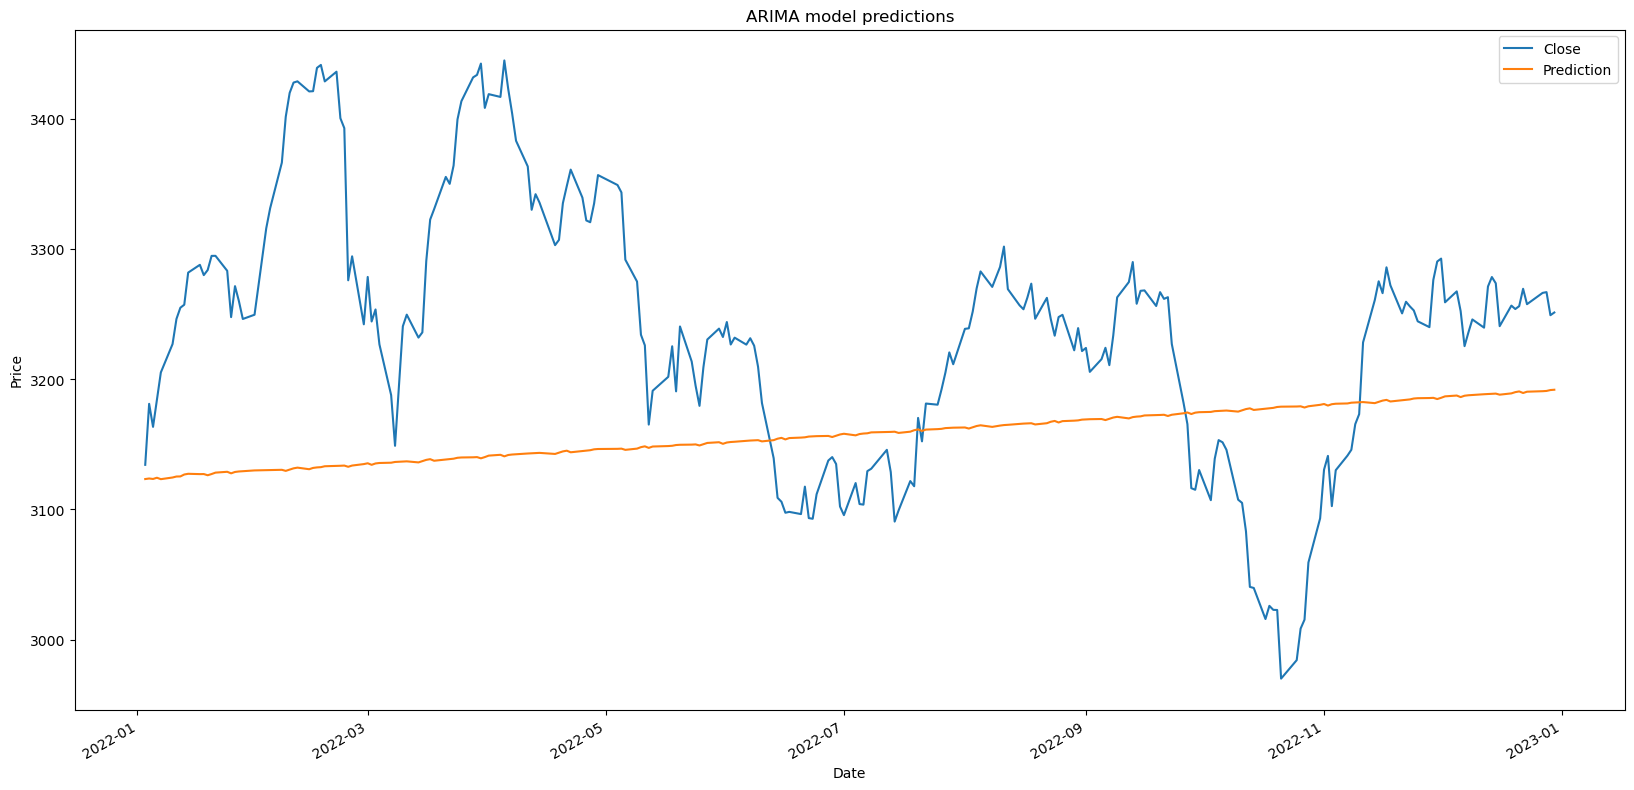

In [13]:
# Predicting test data
predictions = results.forecast(len(sti_test)).values
sti_test["Prediction"] = predictions

# Plotting actual and prediction
sti_test[["Close","Prediction"]].plot(figsize=(20,10), title="ARIMA model predictions", ylabel="Price")

In [14]:
# Calculating the mean square error of actual values and predictions
mse_sarimax = metrics.mean_squared_error(sti_test["Close"], sti_test["Prediction"])
print(f"SARIMAX prediction give a mean square error of {mse_sarimax}")

SARIMAX prediction give a mean square error of 17774.97019620984


# 2. Using LSTM to predict stock prices

In [15]:
# Pick up Close column as array for data before 2021
training_set = sti_df[sti_df.index.year<2021][["Close"]].values # Array need to be in 2D
testing_set = sti_df[sti_df.index.year>=2021][["Close"]].values

In [16]:
# Perform scaling to trasform data between zero and one
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set)

## 2.1 Data preprocessing
Standardise data and split data into X and Y then into 50 steps data 

In [17]:
# Restructure input to have a certain a amount of steps to one output
X_train = []
y_train = []
X_test = []
y_test = []

# 50 steps for one input, about 5 month for 1 value for train set
for i in range(50, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-50:i, 0]) # Starting from 0 row to 100th row
    y_train.append(training_set_scaled[i,0]) # From 50th row onwards
X_train, y_train = np.array(X_train), np.array(y_train)

# Combine last 50 training data with test data
testing_set_scaled = np.vstack((training_set_scaled[-50:], testing_set_scaled))

# 50 steps for one input, about 5 month for 1 value for test set
for i in range(50, len(testing_set_scaled)):
    X_test.append(testing_set_scaled[i-50:i, 0])
    y_test.append(testing_set_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [18]:
# Checking shape of train data to make sure value is same
print(X_train.shape)
y_train.shape

(8191, 50)


(8191,)

In [19]:
# Reshape X_train data into 3D array as RNN only accept 3D data
# Shape(number of records, number of steps, 1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

##  2.2 Building LSTM RNN
Two hidden layers and an output layer

In [20]:
# Import libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout # Stopping a certain amount of neurons to prevent overfitting

In [21]:
# Initialise RNN
LSTM_regressor = Sequential()

In [22]:
# Add LSTM layers and dropout regularization
# Units: Number of neurons in the hidden layer
# Activation: Activation function to be used, ReLu, sigmoid or tanh
# Input_shape: Input shape to be provided to the LSTM RNN
LSTM_regressor.add(LSTM (units= 100, return_sequences = True, input_shape = (X_train.shape[1], 1))) # Adding 100 neurons
LSTM_regressor.add(Dropout(0.2))

In [24]:
# Adding a second LSTM layer and Dropout regularisation
LSTM_regressor.add(LSTM(units= 100))
LSTM_regressor.add(Dropout(0.2))

In [25]:
# Adding the output layer
LSTM_regressor.add(Dense(units=1))

In [26]:
# See summary of the model
LSTM_regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


## 2.3 Compiling LSTM RNN
Select the optimizer process, along with the training process and number of epoch to use with batch size. Batch size indicate how much input data to be pass to RNN at a time during training

In [27]:
# Compiling RNN, with mean squared error as the cost function
LSTM_regressor.compile(optimizer="adam", loss="mean_squared_error")

In [28]:
# Fitting RNN to training set
history = LSTM_regressor.fit(X_train, y_train, validation_split=0.2, epochs=75, batch_size=32)

Epoch 1/75
205/205 [==============================] - 10s 39ms/step - loss: 0.0056 - val_loss: 5.0620e-04
Epoch 2/75
205/205 [==============================] - 9s 42ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/75
205/205 [==============================] - 9s 42ms/step - loss: 0.0013 - val_loss: 4.2624e-04
Epoch 4/75
205/205 [==============================] - 8s 40ms/step - loss: 0.0011 - val_loss: 9.1458e-04
Epoch 5/75
205/205 [==============================] - 8s 38ms/step - loss: 0.0011 - val_loss: 5.1218e-04
Epoch 6/75
205/205 [==============================] - 8s 37ms/step - loss: 9.4337e-04 - val_loss: 4.3985e-04
Epoch 7/75
205/205 [==============================] - 8s 39ms/step - loss: 9.5436e-04 - val_loss: 5.7298e-04
Epoch 8/75
205/205 [==============================] - 8s 38ms/step - loss: 8.5995e-04 - val_loss: 2.7478e-04
Epoch 9/75
205/205 [==============================] - 8s 38ms/step - loss: 8.2940e-04 - val_loss: 0.0010
Epoch 10/75
205/205 [=========================

In [29]:
# Saving model for loading later
LSTM_regressor.save("lstm_univariate.h5")

## 2.4 Making predictions and visualizing data



In [30]:
# Saving loss and val loss for plotting
lstm_univariate = history.history

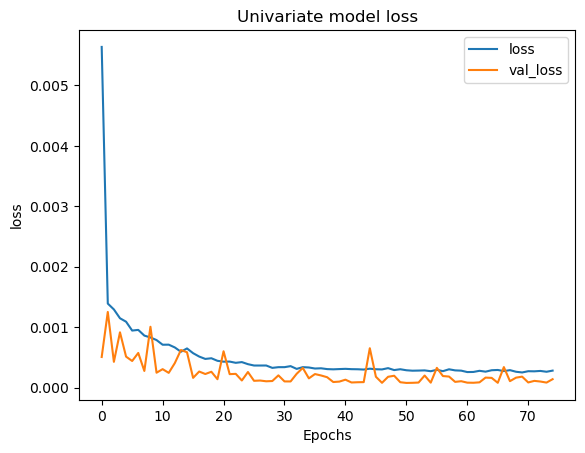

In [31]:
# Plotting loss and val loss
plt.plot(lstm_univariate['loss'], label="loss")
plt.plot(lstm_univariate['val_loss'], label="val_loss")
plt.title("Univariate model loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

In [32]:
# Finding the predictions and inverse transform for plotting
prediction = LSTM_regressor.predict(X_test)
prediction_inverse = sc.inverse_transform(prediction)

16/16 [==============================] - 1s 9ms/step


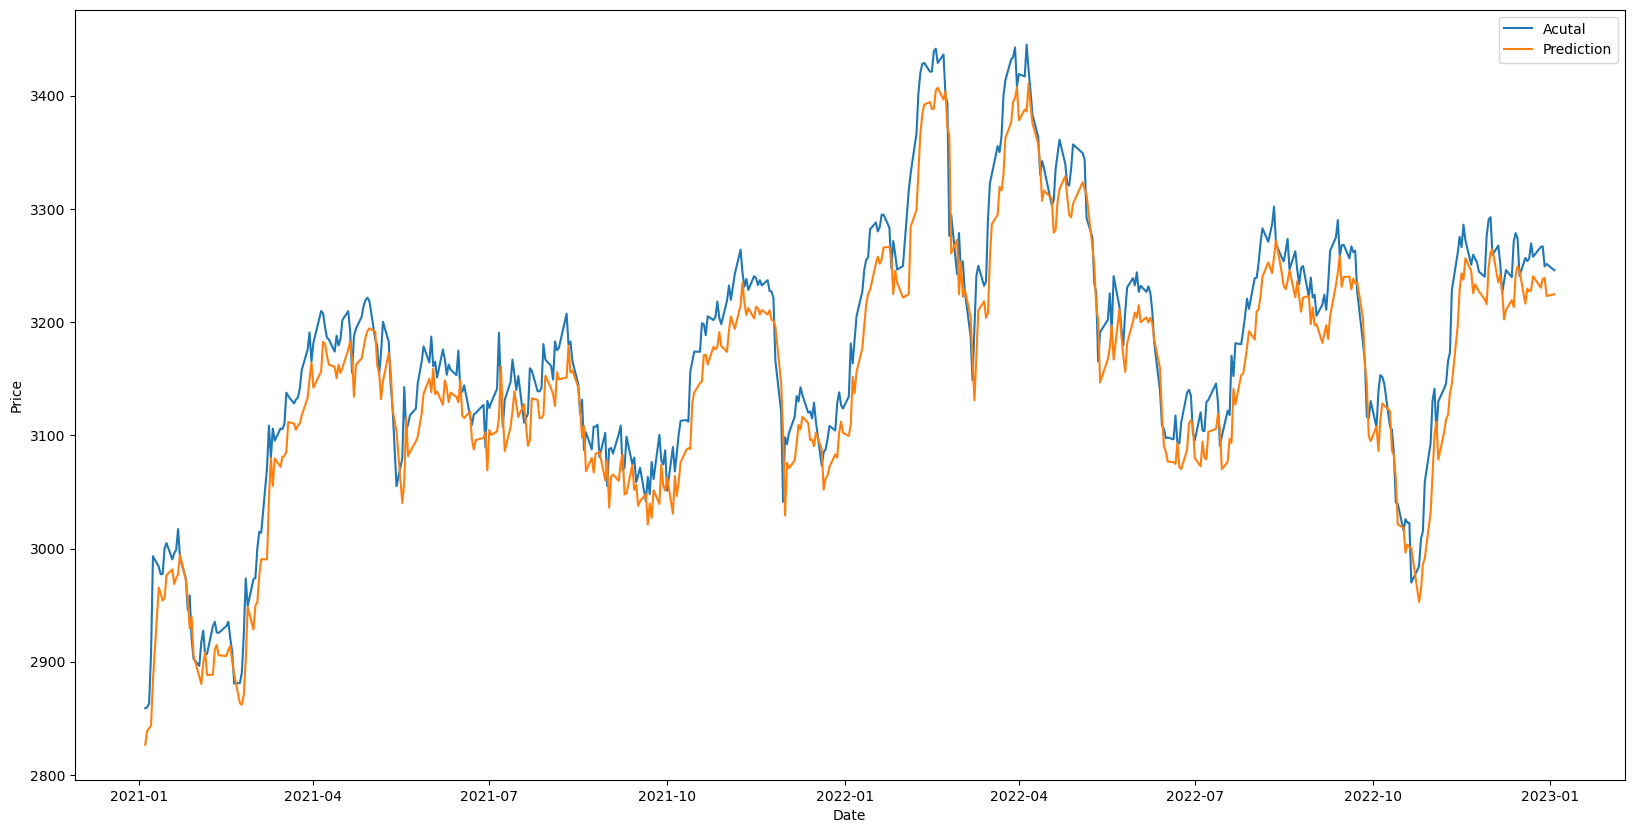

In [33]:
# Combine actual and prediction as dataframe for plotting
actual_predict_df = sti_df[sti_df.index.year>=2021][["Close"]]
actual_predict_df["prediction"] = prediction_inverse

# Plotting prediction with actual values
plt.figure(figsize = (20,10))
plt.plot(actual_predict_df, label=["Acutal","Prediction"])
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

In [34]:
# Calculating MSE
mse_lstm = metrics.mean_squared_error(prediction, y_test)
print(f"LSTM univariate prediction give a mean square error of {mse_lstm}")

LSTM univariate prediction give a mean square error of 0.00012889335726477653


# 3. Multivariate LSTM to predict stock prices

## 3.1 Creating functions to input features. 
### Functions created are able to calculate with different input range of period such as from 2 periods to 100 periods and above. 
### Periods here refers to timeframe being looked at such as days, hours or minutes.
### For this model, day is used as the period.

In [35]:
# Make a duplicate copy
sti_multi = sti_df.copy()

In [36]:
def ema(file_name, period, price, smoothing = 2, column_name="ema_period"):
    
    """
    Calculation of EMA is as follows:

    EMA = (price * (smoothing / (1 + duration)) + previous_ema * (1 - (smoothing / (1 + duration)))

    """
    previous_ema = file_name.loc[:period, price].mean() #Getting average to be use as first ema
    
    ema_list = [previous_ema] # Storing first ema as a list and to store other ema values

    for i in range(period-1):
        #Insert 0 into elements before first EMA as first number period of values will not have ema values
        ema_list.insert(0, 0)
    
    # Calculating EMA for the rest
    for row_num in range(period, len(file_name[price])):
        current_price = file_name.loc[row_num, price]
        ema_temp = current_price * (smoothing / (1 + period)) + previous_ema * (1 - (smoothing / (1 + period)))
        previous_ema = ema_temp
        ema_list.append(ema_temp) # Appending of ema into list

    # Adding new column and add ema to it    
    file_name[f"{column_name}_{period}"] = ema_list

def macd(file_name):
    """
    Calculation for MACD as follows:
    MACD = ema_period_12 - ema_period_26
    Signal = ema_period_9 of MACD
    MACD_histogram = MACD - Signal

    Make sure dataframe has column "ema_period_26" and "ema_period_12"
    """

    file_name["macd"] = file_name["ema_period_12"] - file_name["ema_period_26"]
    ema(file_name, period=9, price="macd", column_name="signal_of_macd")
    file_name["macd_histogram"] = file_name["macd"] - file_name["signal_of_macd_9"]


def stochastic(file_name, period = 14, price = "Close"):
    """
    Calculation for stochastic is ((Closing_price - period_low) / (period_high - period_low)) * 100
    Period is define by user, default setting is 14
    Additional 2 columns will be created to show the high and low of the defined period
    """
    file_name[f"high_period_{period}"] = file_name[price].rolling(period).max()
    file_name[f"low_period_{period}"] = file_name[price].rolling(period).min()

    file_name[f"stochastic_period_{period}"] = ((file_name[price] - file_name[f"low_period_{period}"]) / (file_name[f"high_period_{period}"] - file_name[f"low_period_{period}"])) * 100


In [37]:
# Calculating ema
sti_multi.reset_index(inplace=True) # Reset index for easier ema calculation

ema(sti_multi,5,"Close")

# Calculating stochastic 
stochastic(sti_multi, period = 5)
stochastic(sti_multi, period = 10)

# Calculating ema for 12 and 26 periods to calculate macd
ema(sti_multi,12,"Close")
ema(sti_multi,26,"Close")
macd(sti_multi)

In [38]:
# Calculating change of ema period 5, 10, 50
sti_multi["ema_period_5_diff"] = sti_multi["ema_period_5"].diff()

# Calculating change of macd
sti_multi["macd_diff"] = sti_multi["macd"].diff()

# Drop na values
sti_multi.dropna(axis=0)

,Date,Open,High,Low,Close,Volume,Close_diff,ema_period_5,high_period_5,low_period_5,...,high_period_10,low_period_10,stochastic_period_10,ema_period_12,ema_period_26,macd,signal_of_macd_9,macd_histogram,ema_period_5_diff,macd_diff
9,1988-01-12,870.500000,870.500000,870.500000,870.500000,0,21.400024,872.609733,911.500000,849.099976,...,911.500000,810.900024,59.244523,0.000000,0.000000,0.000000,0.000000,0.000000,-1.054866,0.000000
10,1988-01-13,853.900024,853.900024,853.900024,853.900024,0,-16.599976,866.373163,911.500000,849.099976,...,911.500000,810.900024,42.743549,0.000000,0.000000,0.000000,0.000000,0.000000,-6.236569,0.000000
11,1988-01-14,861.599976,861.599976,861.599976,861.599976,0,7.699951,864.782101,895.299988,849.099976,...,911.500000,823.200012,43.488073,860.699998,0.000000,860.699998,172.140000,688.559998,-1.591063,860.699998
12,1988-01-15,869.799988,869.799988,869.799988,869.799988,0,8.200012,866.454730,870.500000,849.099976,...,911.500000,833.599976,46.469834,862.099997,0.000000,862.099997,310.131999,551.967998,1.672629,1.399998
13,1988-01-18,917.599976,917.599976,917.599976,917.599976,0,47.799988,883.503145,917.599976,853.900024,...,917.599976,849.099976,100.000000,870.638455,0.000000,870.638455,422.233290,448.405165,17.048415,8.538458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8740,2022-12-27,3277.580078,3277.939941,3264.030029,3266.379883,108508800,8.679932,3261.872398,3269.530029,3253.969971,...,3278.570068,3240.810059,67.716678,3259.115672,3246.629577,12.486095,15.894956,-3.408861,2.253742,-0.259259
8741,2022-12-28,3257.750000,3270.330078,3256.239990,3266.969971,121539700,0.590088,3263.571589,3269.530029,3256.189941,...,3278.570068,3240.810059,69.279410,3260.324025,3248.136272,12.187753,15.153515,-2.965762,1.699191,-0.298342
8742,2022-12-29,3255.100098,3257.000000,3234.929932,3249.239990,138022600,-17.729980,3258.794390,3269.530029,3249.239990,...,3273.750000,3240.810059,25.591823,3258.618789,3248.218029,10.400760,14.202964,-3.802204,-4.777200,-1.786993
8743,2022-12-30,3259.229980,3261.879883,3247.850098,3251.320068,106326500,2.080078,3256.302949,3266.969971,3249.239990,...,3269.530029,3240.810059,36.594779,3257.495909,3248.447810,9.048099,13.171991,-4.123892,-2.491440,-1.352661


In [39]:
# Setting date as index for splitting to train and test data sets
sti_multi.index = sti_multi["Date"]

# Removing first 25 data as ema calculation could not be done
sti_multi = sti_multi.iloc[25:]

In [40]:
# Pick up Close column as array for data before 2021
training_set = sti_multi[sti_multi.index.year<2021][["ema_period_5_diff", "stochastic_period_5", "macd_diff", "stochastic_period_10", "Close"]] # Array need to be in 2D
testing_set = sti_multi[sti_multi.index.year>=2021][["ema_period_5_diff", "stochastic_period_5", "macd_diff", "stochastic_period_10", "Close"]]

## 3.2 Data preprocessing
Standardise data and split data into X and Y then into 50 steps data 

In [41]:
# Transform data to standardise all
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set)

In [42]:
# Restructure input to have a certain a amount of steps to one output
X_train = []
y_train = []
X_test = []
y_test = []

# 50 steps for one input, about 5 month for 1 value for train set
for i in range(50, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-50:i,:]) # Starting from 0 row to 100th row
    y_train.append(training_set_scaled[i,-1]) # From 50th row onwards, from last column
X_train, y_train = np.array(X_train), np.array(y_train)

# Combine last 50 training data with test data
testing_set_scaled = np.vstack((training_set_scaled[-50:], testing_set_scaled))

# 50 steps for one input, about 5 month for 1 value for test set
for i in range(50, len(testing_set_scaled)):
    X_test.append(testing_set_scaled[i-50:i,:])
    y_test.append(testing_set_scaled[i,-1])

X_test, y_test = np.array(X_test), np.array(y_test)

##  3.3 Building LSTM RNN
Three hidden layers and an output layer

In [43]:
# Initialise RNN
LSTM_regressor = Sequential()

# Input_shape: Input shape to be provided to the LSTM RNN
LSTM_regressor.add(LSTM (units= 100, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2]))) # input shape here refer to steps input and number of features
LSTM_regressor.add(Dropout(0.2))

# Adding a fifth LSTM layer and some Dropout regularisation
LSTM_regressor.add(LSTM(units= 100))
LSTM_regressor.add(Dropout(0.2))

# Adding the output layer
LSTM_regressor.add(Dense(units=1))

# See summary of the model
LSTM_regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 100)           42400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
_________________________________________________________________


## 3.4 Compiling LSTM RNN
Select the optimizer process, along with the training process and number of epoch to use with batch size. Batch size indicate how much input data to be pass to RNN at a time during training

In [44]:
# Compiling RNN, with mean squared error as the cost function
LSTM_regressor.compile(optimizer="adam", loss="mean_squared_error")

In [45]:
# Fitting RNN to training set
history = LSTM_regressor.fit(X_train, y_train, validation_split=0.2, epochs=75, batch_size=32)

Epoch 1/75
205/205 [==============================] - 10s 40ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 2/75
205/205 [==============================] - 8s 41ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 3/75
205/205 [==============================] - 8s 40ms/step - loss: 0.0013 - val_loss: 1.5634e-04
Epoch 4/75
205/205 [==============================] - 8s 41ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/75
205/205 [==============================] - 9s 42ms/step - loss: 0.0010 - val_loss: 1.5330e-04
Epoch 6/75
205/205 [==============================] - 8s 41ms/step - loss: 9.2026e-04 - val_loss: 1.5157e-04
Epoch 7/75
205/205 [==============================] - 9s 43ms/step - loss: 8.2764e-04 - val_loss: 2.2036e-04
Epoch 8/75
205/205 [==============================] - 9s 42ms/step - loss: 8.1567e-04 - val_loss: 2.2539e-04
Epoch 9/75
205/205 [==============================] - 8s 41ms/step - loss: 7.4145e-04 - val_loss: 4.0837e-04
Epoch 10/75
205/205 [=============================

In [46]:
# Saving model for loading later
LSTM_regressor.save("lstm_multivariate.h5")

## 3.5 Making predictions and visualizing data
Loss plot is plotted with validation loss to ensure no over or under fitting

In [47]:
# Saving loss data for plotting
lstm_multivariate = history.history

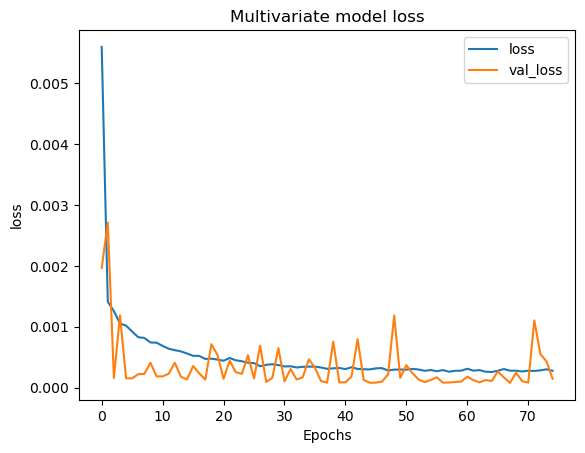

In [48]:
# Plotting loss and val loss
plt.plot(lstm_multivariate['loss'], label="loss")
plt.plot(lstm_multivariate['val_loss'], label="val_loss")
plt.title("Multivariate model loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

In [52]:
# Finding the predictions and inverse transform for plotting
prediction = LSTM_regressor.predict(X_test)

prediction_combined = np.concatenate((testing_set_scaled[50:,0:4],prediction), axis=1)
prediction_inverse = sc.inverse_transform(prediction_combined)

16/16 [==============================] - 0s 9ms/step


In [53]:
# Calculating MSE
mse_lstm = metrics.mean_squared_error(prediction, y_test)
print(f"LSTM multivariate prediction give a mean square error of {mse_lstm}")

LSTM multivariate prediction give a mean square error of 0.00013255055062727793


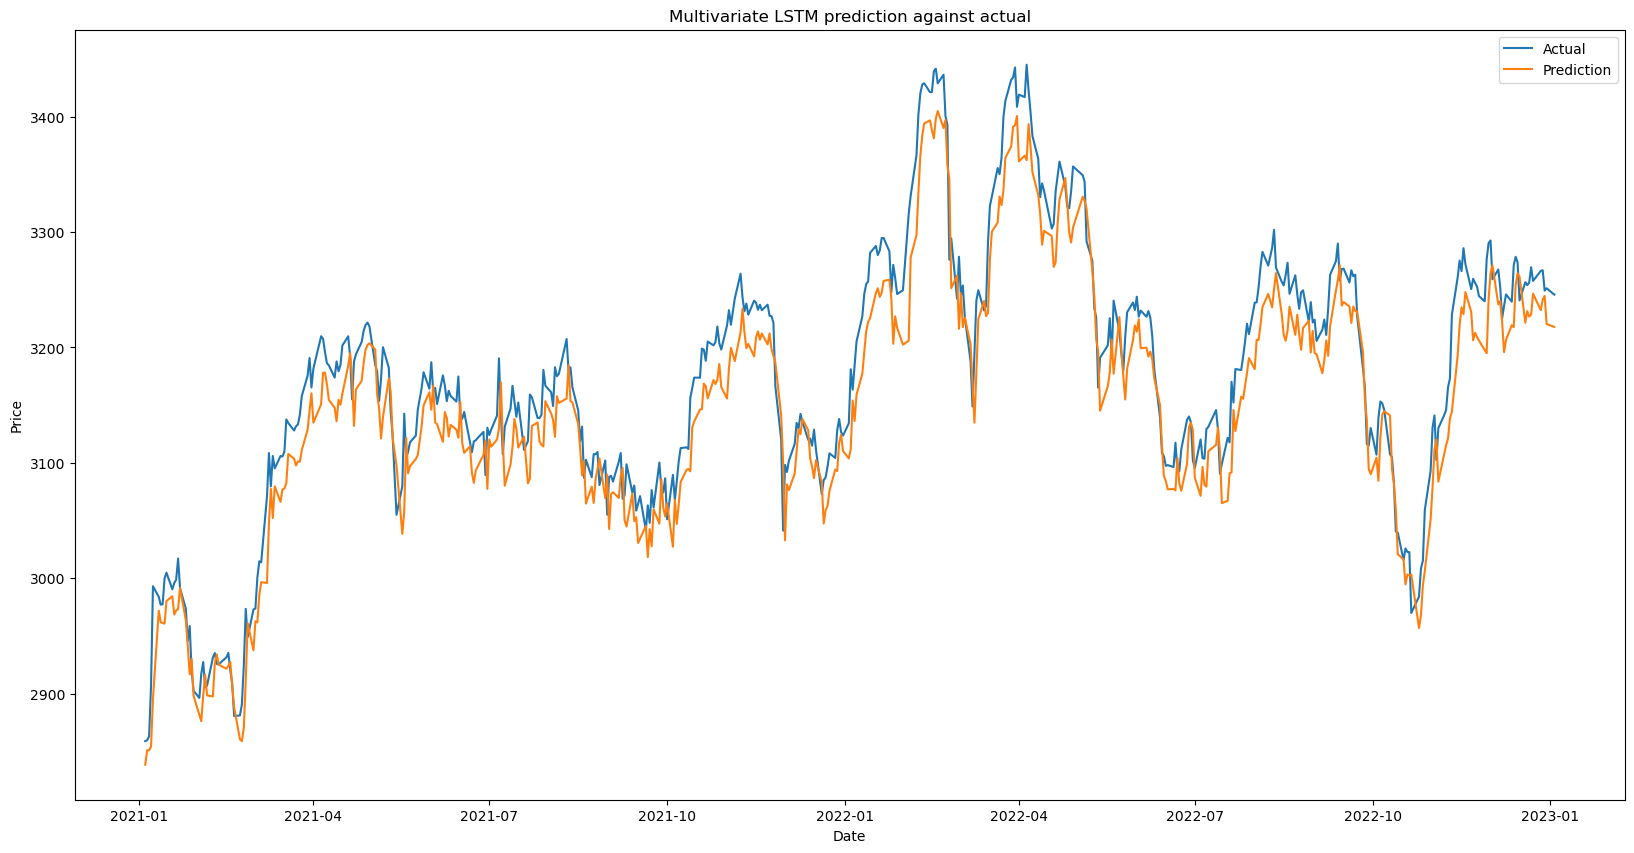

In [62]:
# Combine actual and prediction as dataframe for plotting
actual_predict_df = sti_df[sti_df.index.year>=2021][["Close"]]
actual_predict_df["prediction"] = prediction_inverse[:,-1]

# Plotting prediction with actual values
plt.figure(figsize = (20,10))
plt.plot(actual_predict_df, label=["Actual","Prediction"])
plt.title("Multivariate LSTM prediction against actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()